In [17]:
import cv2
import numpy as np 
import glob
from tqdm import tqdm
import PIL.ExifTags
import PIL.Image
from matplotlib import pyplot as plt 
import sys 
sys.path.append("../")
import config

In [40]:
from imutils import paths

In [18]:
import pickle as pkl

In [15]:
#Function to create point cloud file
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [16]:
#Function that Downsamples image x number (reduce_factor) of times. 
def downsample_image(image, reduce_factor):
	for i in range(0,reduce_factor):
		#Check if image is color or grayscale
		if len(image.shape) > 2:
			row,col = image.shape[:2]
		else:
			row,col = image.shape

		image = cv2.pyrDown(image, dstsize= (col//2, row // 2))
	return image

In [22]:
ls

 Volume in drive D is Main Storage
 Volume Serial Number is DAD5-8CD9

 Directory of D:\Academics\Computer Vision\Project 6\StereoVision\notebooks

04/25/2022  02:04 AM    <DIR>          .
04/25/2022  01:02 AM    <DIR>          ..
04/21/2022  09:58 AM    <DIR>          .ipynb_checkpoints
04/25/2022  02:04 AM             6,912 Displaying_two_views.ipynb
04/19/2022  08:10 PM         1,310,103 SIFT.ipynb
               2 File(s)      1,317,015 bytes
               3 Dir(s)  152,229,380,096 bytes free


In [33]:
#Load camera parameters
file = open("../calib/CameraMatrixL.pkl", 'rb')
KL = pkl.load(file)
file = open("../calib/CameraMatrixR.pkl", 'rb')
KR = pkl.load(file)
file = open("../calib/CameraDistCoeffL.pkl", 'rb')
distL = pkl.load(file)
file = open("../calib/CameraDistCoeffR.pkl", 'rb')
distR = pkl.load(file)

In [97]:
cap = cv2.VideoCapture(3)
cap2 = cv2.VideoCapture(0)


if not cap.isOpened() or not cap2.isOpened():
    print("Cannot open camera")
    exit()
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    ret2, frame2 = cap2.read()
    
    if not ret or not ret2:
        print("no feed from camera")
        break
    
    h,w = frame.shape[:2]
    
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(KL,distL,(w,h),1,(w,h))
    
    img_1_undistorted = cv2.undistort(frame, KL, distL, None, new_camera_matrix)
    img_2_undistorted = cv2.undistort(frame2, KR, distR, None, new_camera_matrix)
    
    #Downsample each image 3 times (because they're too big)
    img_1_downsampled = downsample_image(img_1_undistorted,1)
    img_2_downsampled = downsample_image(img_2_undistorted,1)
    
    win_size = 10
    min_disp = -1
    max_disp = 255 #min_disp * 9
    num_disp = max_disp - min_disp # Needs to be divisible by 16
    
    #Create Block matching object. 
    stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
        numDisparities = num_disp,
        blockSize = 10,
        uniquenessRatio = 5,
        speckleWindowSize = 5,
        speckleRange = 5,
        disp12MaxDiff = 2,
        P1 = 8*3*win_size**2,#8*3*win_size**2,
        P2 =32*3*win_size**2) #32*3*win_size**2)

    disparity_map = stereo.compute(img_1_downsampled, img_2_downsampled)

    # Display the resulting frame
    cv2.imshow('Stereo 1', frame)
    cv2.imshow('stereo 2',frame2)
    cv2.imshow('depth', disparity_map)
    if cv2.waitKey(1) == ord('q'):
        break
# When everything done, release the capture
cap.release()
cap2.release()
cv2.destroyAllWindows()

In [44]:
image_paths = list(paths.list_images("./testData"))
print(len(image_paths))
print(image_paths)

26
['./testData\\0L.jpg', './testData\\0R.jpg', './testData\\10L.jpg', './testData\\10R.jpg', './testData\\11L.jpg', './testData\\11R.jpg', './testData\\12L.jpg', './testData\\12R.jpg', './testData\\1L.jpg', './testData\\1R.jpg', './testData\\2L.jpg', './testData\\2R.jpg', './testData\\3L.jpg', './testData\\3R.jpg', './testData\\4L.jpg', './testData\\4R.jpg', './testData\\5L.jpg', './testData\\5R.jpg', './testData\\6L.jpg', './testData\\6R.jpg', './testData\\7L.jpg', './testData\\7R.jpg', './testData\\8L.jpg', './testData\\8R.jpg', './testData\\9L.jpg', './testData\\9R.jpg']


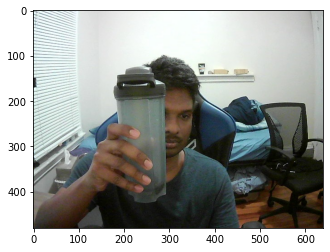

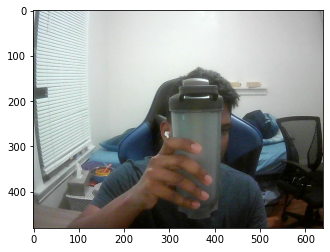

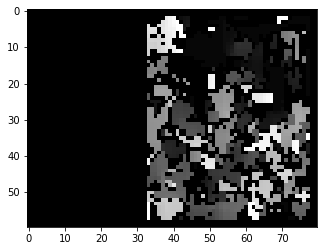

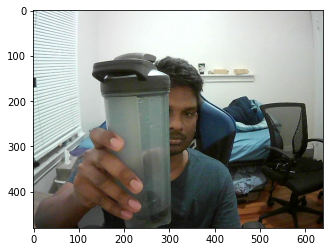

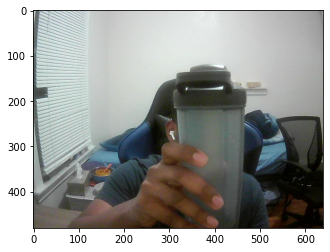

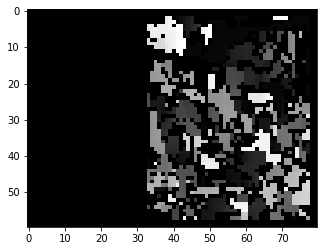

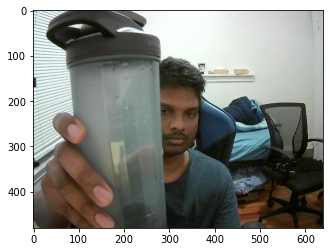

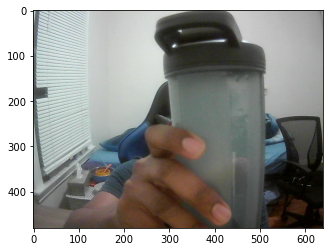

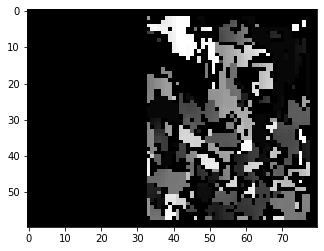

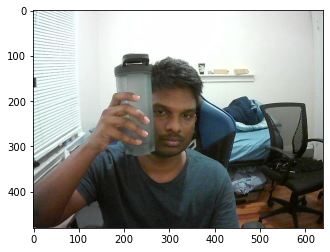

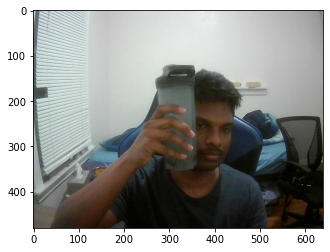

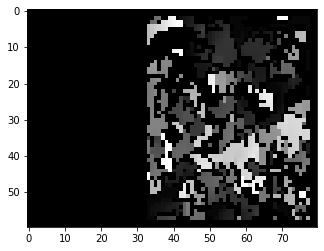

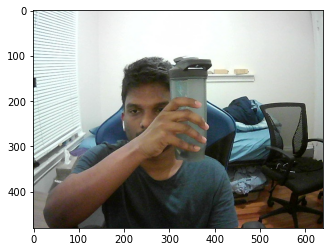

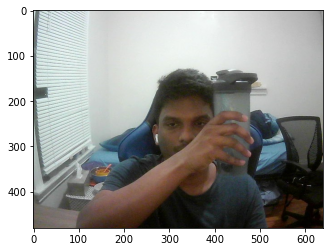

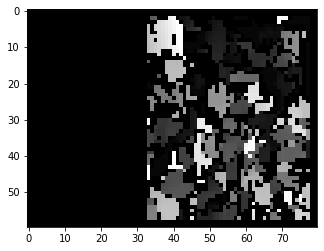

In [95]:
for i in range(0,5):
    # Capture frame-by-frame
    frame = cv2.imread("./testData/"+str(i)+"L.jpg")
    frame2 = cv2.imread("./testData/"+str(i)+"R.jpg")
    
    h,w = frame.shape[:2]
    
    new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(KL,distL,(w,h),1,(w,h))
    
    img_1_undistorted = cv2.undistort(frame, KL, distL, None, new_camera_matrix)
    img_2_undistorted = cv2.undistort(frame2, KR, distR, None, new_camera_matrix)
    
    #Downsample each image 3 times (because they're too big)
    img_1_downsampled = downsample_image(img_1_undistorted,3)
    img_2_downsampled = downsample_image(img_2_undistorted,3)
    
    img1 = cv2.cvtColor(img_1_undistorted, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img_2_undistorted, cv2.COLOR_BGR2GRAY)
    
    img1 = cv2.cvtColor(img_1_downsampled, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img_2_downsampled, cv2.COLOR_BGR2GRAY)
    
    win_size = 5
    min_disp = -1
    max_disp = 15 #min_disp * 9
    num_disp = max_disp - min_disp # Needs to be divisible by 16
    
    #Create Block matching object. 
    # stereo = cv2.StereoSGBM_create(minDisparity= min_disp,
    #     numDisparities = num_disp,
    #     blockSize = 1,
    #     uniquenessRatio = 5,
    #     speckleWindowSize = 5,
    #     speckleRange = 5,
    #     disp12MaxDiff = 2,
    #     P1 = 8*3*win_size**2,#8*3*win_size**2,
    #     P2 =32*3*win_size**2) #32*3*win_size**2)
    
    stereo = cv2.StereoBM_create(numDisparities=32, blockSize=5)

    disparity_map = stereo.compute(img1, img2)

    # Display the resulting frame
    plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
    plt.show()
    # plt.imshow(cv2.cvtColor(img_1_undistorted,cv2.COLOR_BGR2RGB))
    # plt.show()
    # plt.imshow(cv2.cvtColor(img_2_undistorted,cv2.COLOR_BGR2RGB))
    # plt.show()
    plt.imshow(cv2.cvtColor(frame2,cv2.COLOR_BGR2RGB))
    plt.show()
    plt.imshow(disparity_map, 'gray')
    plt.show()

In [51]:
cap.release()
cap2.release()

In [ ]:
img1 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity = stereo.compute(img1, img2).astype(np.float32) / 16.0
disparity = (disparity-16)/16

# if frame is read correctly ret is True
if not ret:
    print("Can't receive frame (stream end?). Exiting ...")
    break
# # Our operations on the frame come here
# gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [ ]:
import numpy as np 
import cv2

# Check for left and right camera IDs
# These values can change depending on the system
CamL_id = 0 # Camera ID for left camera
CamR_id = 3 # Camera ID for right camera

CamL= cv2.VideoCapture(CamL_id)
CamR= cv2.VideoCapture(CamR_id)

# Reading the mapping values for stereo image rectification
cv_file = cv2.FileStorage("data/stereo_rectify_maps.xml", cv2.FILE_STORAGE_READ)
Left_Stereo_Map_x = cv_file.getNode("Left_Stereo_Map_x").mat()
Left_Stereo_Map_y = cv_file.getNode("Left_Stereo_Map_y").mat()
Right_Stereo_Map_x = cv_file.getNode("Right_Stereo_Map_x").mat()
Right_Stereo_Map_y = cv_file.getNode("Right_Stereo_Map_y").mat()
cv_file.release()

def nothing(x):
    pass

cv2.namedWindow('disp',cv2.WINDOW_NORMAL)
cv2.resizeWindow('disp',600,600)

cv2.createTrackbar('numDisparities','disp',1,17,nothing)
cv2.createTrackbar('blockSize','disp',5,50,nothing)
cv2.createTrackbar('preFilterType','disp',1,1,nothing)
cv2.createTrackbar('preFilterSize','disp',2,25,nothing)
cv2.createTrackbar('preFilterCap','disp',5,62,nothing)
cv2.createTrackbar('textureThreshold','disp',10,100,nothing)
cv2.createTrackbar('uniquenessRatio','disp',15,100,nothing)
cv2.createTrackbar('speckleRange','disp',0,100,nothing)
cv2.createTrackbar('speckleWindowSize','disp',3,25,nothing)
cv2.createTrackbar('disp12MaxDiff','disp',5,25,nothing)
cv2.createTrackbar('minDisparity','disp',5,25,nothing)

# Creating an object of StereoBM algorithm
stereo = cv2.StereoBM_create()

while True:

	# Capturing and storing left and right camera images
	retL, imgL= CamL.read()
	retR, imgR= CamR.read()
	
	# Proceed only if the frames have been captured
	if retL and retR:
		imgR_gray = cv2.cvtColor(imgR,cv2.COLOR_BGR2GRAY)
		imgL_gray = cv2.cvtColor(imgL,cv2.COLOR_BGR2GRAY)

		# Applying stereo image rectification on the left image
		Left_nice= cv2.remap(imgL_gray,
							Left_Stereo_Map_x,
							Left_Stereo_Map_y,
							cv2.INTER_LANCZOS4,
							cv2.BORDER_CONSTANT,
							0)
		
		# Applying stereo image rectification on the right image
		Right_nice= cv2.remap(imgR_gray,
							Right_Stereo_Map_x,
							Right_Stereo_Map_y,
							cv2.INTER_LANCZOS4,
							cv2.BORDER_CONSTANT,
							0)

		# Updating the parameters based on the trackbar positions
		numDisparities = cv2.getTrackbarPos('numDisparities','disp')*16
		blockSize = cv2.getTrackbarPos('blockSize','disp')*2 + 5
		preFilterType = cv2.getTrackbarPos('preFilterType','disp')
		preFilterSize = cv2.getTrackbarPos('preFilterSize','disp')*2 + 5
		preFilterCap = cv2.getTrackbarPos('preFilterCap','disp')
		textureThreshold = cv2.getTrackbarPos('textureThreshold','disp')
		uniquenessRatio = cv2.getTrackbarPos('uniquenessRatio','disp')
		speckleRange = cv2.getTrackbarPos('speckleRange','disp')
		speckleWindowSize = cv2.getTrackbarPos('speckleWindowSize','disp')*2
		disp12MaxDiff = cv2.getTrackbarPos('disp12MaxDiff','disp')
		minDisparity = cv2.getTrackbarPos('minDisparity','disp')
		
		# Setting the updated parameters before computing disparity map
		stereo.setNumDisparities(numDisparities)
		stereo.setBlockSize(blockSize)
		stereo.setPreFilterType(preFilterType)
		stereo.setPreFilterSize(preFilterSize)
		stereo.setPreFilterCap(preFilterCap)
		stereo.setTextureThreshold(textureThreshold)
		stereo.setUniquenessRatio(uniquenessRatio)
		stereo.setSpeckleRange(speckleRange)
		stereo.setSpeckleWindowSize(speckleWindowSize)
		stereo.setDisp12MaxDiff(disp12MaxDiff)
		stereo.setMinDisparity(minDisparity)

		# Calculating disparity using the StereoBM algorithm
		disparity = stereo.compute(Left_nice,Right_nice)
		# NOTE: Code returns a 16bit signed single channel image,
		# CV_16S containing a disparity map scaled by 16. Hence it 
		# is essential to convert it to CV_32F and scale it down 16 times.

		# Converting to float32 
		disparity = disparity.astype(np.float32)

		# Scaling down the disparity values and normalizing them 
		disparity = (disparity/16.0 - minDisparity)/numDisparities

		# Displaying the disparity map
		cv2.imshow("disp",disparity)

		# Close window using esc key
		if cv2.waitKey(1) == 27:
			break
	
	else:
		CamL= cv2.VideoCapture(CamL_id)
		CamR= cv2.VideoCapture(CamR_id)
